# YOLO v1 

# Setup

In [1]:
import os
import sys
import json
import pathlib
from typing import (
    List,
    Dict,
    Tuple
)

import numpy as np
import tensorflow as tf
from tensorflow import keras   # MUST to make sure of using tensorflow.keras, not keras
from tensorflow.keras.models import (
    Model,
)
from tensorflow.keras.layers import (
    Layer,
    Normalization,
)
import tensorflow_datasets as tfds

## PYTHONPATH

In [2]:
path_to_lib: str = str(pathlib.Path(os.path.join(os.getcwd(), "../../..")).resolve())
assert isinstance(path_to_lib, str)
sys.path.append(path_to_lib)

In [3]:
%load_ext autoreload
%autoreload 2

from util_opencv.image import (
    get_image,
    show_image,
)
from util_tf.nn import (
    train,
    get_early_stopping_callback,
    get_tensorboard_callback,
)
from util_tf.tfds.voc import (
    generate_yolo_v1_labels_from_pascal_voc,
    generate_yolo_v1_data_from_pascal_voc,
    PASCAL_VOC_CLASSES,
)

from constant import (
    DEBUG_LEVEL,
    TYPE_FLOAT,
    YOLO_V1_PREDICTION_NUM_CLASSES,
    YOLO_GRID_SIZE,
    YOLO_V1_IMAGE_WIDTH,
    YOLO_V1_IMAGE_HEIGHT,
    YOLO_V1_LABEL_LENGTH,
    YOLO_V1_LABEL_INDEX_CP,
    YOLO_V1_LABEL_INDEX_X,
    YOLO_V1_LABEL_INDEX_Y,
    YOLO_V1_LABEL_INDEX_W,
    YOLO_V1_LABEL_INDEX_H,
    YOLO_V1_PREDICTION_NUM_PRED,
    YOLO_V1_PREDICTION_NUM_CLASSES
)
from model import (
    layers_config,
    input_shape,
    YOLOModel,
)

In [4]:
S = YOLO_GRID_SIZE
C = YOLO_V1_PREDICTION_NUM_CLASSES
P = YOLO_V1_PREDICTION_NUM_PRED

---
# Data

## TFDS PASCAL VOC

In [5]:
voc, info = tfds.load(
    name='voc', 
    data_dir="/Volumes/SSD/data/tfds/",
    with_info=True,
)
info

INFO:absl:No config specified, defaulting to config: voc/2007
INFO:absl:Load dataset info from /Volumes/SSD/data/tfds/voc/2007/4.0.0
INFO:absl:Reusing dataset voc (/Volumes/SSD/data/tfds/voc/2007/4.0.0)
INFO:absl:Constructing tf.data.Dataset voc for split None, from /Volumes/SSD/data/tfds/voc/2007/4.0.0


tfds.core.DatasetInfo(
    name='voc',
    full_name='voc/2007/4.0.0',
    description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge,
    corresponding to the Classification and Detection competitions.
    
    In the Classification competition, the goal is to predict the set of labels
    contained in the image, while in the Detection competition the goal is to
    predict the bounding box and label of each individual object.
    annotations.
    """,
    config_description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge
    2007, a.k.a. VOC2007.
    
    A total of 9963 images are included in this dataset, where each image
    contains a set of objects, out of 20 different classes, making a total of
    24640 annotated objects.
    
    """,
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    data_path='/Volumes/SSD/data/tfds/voc/2007/4.0.0',
    file_format=tfrecord,
    download_size=868

## YOLO v1 dataset

Dataset in ```(input,label)``` format where input is ```(448,448,3)``` RGB image and label is YOLO v1 label in ```(C,P)``` format where ```P=(cp,x,y,w,h)```.

In [6]:
# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()
train = voc['train'].map(generate_yolo_v1_data_from_pascal_voc)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Input Image

2023-03-12 12:29:01.362228: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(448, 448, 3)


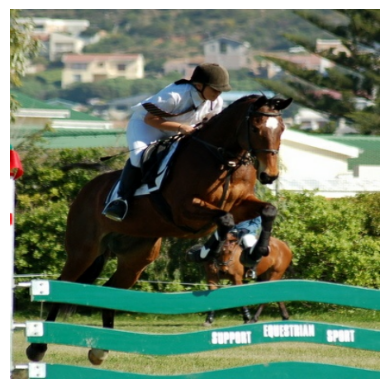

In [ ]:
record = next(train.as_numpy_iterator())
image = record[0]
label = record[1]

print(image.shape)
show_image(image=image.astype(np.uint8), bgr_to_rgb=False)

### Label

In [8]:
for id, cell in enumerate(label.reshape((-1, C+P))):
    cp = cell[YOLO_V1_LABEL_INDEX_CP]
    if cp == 1:
        classes = cell[:YOLO_V1_PREDICTION_NUM_CLASSES]
        print("cell:({},{}) is {}".format(
            int(id / S), 
            int(id % S), 
            PASCAL_VOC_CLASSES[np.argmax(cell[:YOLO_V1_PREDICTION_NUM_CLASSES]==1)]
        ))


cell:(2,2) is person
cell:(3,2) is horse
cell:(4,4) is person
cell:(5,4) is horse


---

# Model

<img src="./image/architecture.png" align="left"/>


* yolo.cfg

```
[net]
batch=64
subdivisions=64
height=448
width=448
channels=3
momentum=0.9
decay=0.0005

learning_rate=0.001
policy=steps
steps=200,400,600,20000,30000
scales=2.5,2,2,.1,.1
max_batches = 40000

[crop]
crop_width=448
crop_height=448
flip=0
angle=0
saturation = 1.5
exposure = 1.5

[convolutional]
filters=64
size=7
stride=2
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=192
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=1024
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=1024
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=1024
size=3
stride=1
pad=1
activation=leaky

#######

[convolutional]
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
size=3
stride=2
pad=1
filters=1024
activation=leaky

[convolutional]
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
size=3
stride=1
pad=1
filters=1024
activation=leaky

[connected]
output=4096
activation=leaky

[dropout]
probability=.5

[connected]
output= 1470
activation=linear

[detection]
classes=20
coords=4
rescore=1
side=7
num=2
softmax=0
sqrt=1
jitter=.2

object_scale=1
noobject_scale=.5
class_scale=1
coord_scale=5
```

In [9]:
input_shape

(448, 448, 3)

In [48]:
model: Model = YOLOModel()

Model: "yolo_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 448, 448, 3)]     0         
                                                                 
 norm (Normalization)        (None, 448, 448, 3)       7         
                                                                 
 conv01 (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 maxpool01 (MaxPooling2D)    (None, 112, 112, 64)      0         
                                                                 
 conv02 (Conv2D)             (None, 112, 112, 192)     110784    
                                                                 
 maxpool02 (MaxPooling2D)    (None, 56, 56, 192)       0         
                                                                 
 conv03_1 (Conv2D)           (None, 56, 56, 192)       3705

---
# Normalize

The model includes a Normalization layer as the first layer. Fit the layer to the sample data. No need to use entire data to fit but adequate samples will suffice. Hence use ```shard(num_shard=10)``` to only use 1/10 of the data.

In [49]:
norm: Layer = model.get_layer(name="norm")
for weight in norm.weights:
    print(weight.name, weight.numpy())

norm/mean:0 [0. 0. 0.]
norm/variance:0 [1. 1. 1.]
norm/count:0 0


In [50]:
norm.axis   # standardize along axis=-1 (depth wise standardization where each pixel is a feature)

(-1,)

In [51]:
def extract_input(input, label):
    """Take input image from (input, label) data"""
    return input

In [52]:
samples = train\
    .shuffle(buffer_size=128)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)\
    .shard(num_shards=10, index=0)\
    .shuffle(buffer_size=128)\
    .map(extract_input)

In [53]:
norm.adapt(samples)

## Verification

### Normalization Layer Weights

Make sure the normalization layer has been adapted.

In [54]:
for weight in norm.weights:
    print(weight.name, weight.numpy())

norm/mean:0 [104.1363 104.1363 104.1363]
norm/variance:0 [4941.7007 4941.7007 4941.7007]
norm/count:0 151130112


### Staandization and Restoration

Make sure the Normalization layer standardize the image that can be restored via $x = standardized(x) * std(x) + \hat{x}$.

(448, 448, 3)


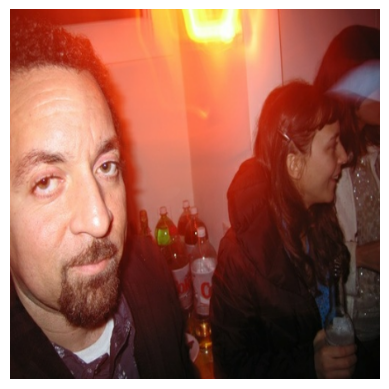

In [55]:
image = next(samples.take(1).as_numpy_iterator())
print(image.shape)
show_image(image=image.astype(np.uint8), bgr_to_rgb=False)

In [56]:
norm(image).numpy().mean()

-0.11576504

In [60]:
norm(image).shape

TensorShape([1, 448, 448, 3])

In [58]:
model.get_layer(name="norm")(image).numpy().mean()

-0.11576504

Verify restored image via $x = standardized(x) * std(x) + \hat{x}$ .

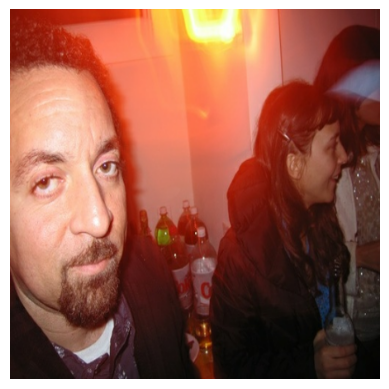

In [79]:
restored = norm(image).numpy().squeeze() * np.sqrt(norm.variance.numpy().squeeze()) + norm.mean.numpy().squeeze()
show_image(image=restored.astype(np.uint8), bgr_to_rgb=False)

---
# Train